# L2464 P=[000]

## Read data into corrMatrix [Always Run]

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.analysis.utils import *
from src.analysis.jk import *
from src.analysis.pivot_method import *
from src.analysis.stats import *
from src.analysis.fitting import *
from src.analysis.plotting import *

import gvar 
import lsqfit
import matplotlib.pyplot as plt 

import multiprocess as MP
import os
import warnings 

warnings.filterwarnings('ignore')

dataDir=os.path.join(os.path.expanduser('~'), "Documents",
                    "LatticeQCD", "PIRHOI2", "L2464")

In [3]:
mpi=0.1378

NOPS=4
NT=20
NCFG=parse_corr_file(dataDir,0,0,NT).shape[0]

corrMatrix=np.array([[parse_corr_file(dataDir,i,j,NT) for i in range(NOPS)] for j in range(NOPS)])
print(corrMatrix.shape)
corrMatrix=np.moveaxis(corrMatrix,[0,1,2,3],[2,3,0,1])
corrMatrix=normalize_corr_matrix(corrMatrix, 2)

niData=niFile_to_dict(os.path.join(os.getcwd(),"OPS","L2464","L2464.hdf5"),"T1g")

is_hermitian(corrMatrix)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 4) + inhomogeneous part.

In [4]:
non_hermitian_configs(corrMatrix)

cfg #145 for ts=[13] non-hermitian to 1e-8


In [5]:
non_hermitian_tolerance(corrMatrix[145,13])

Reached tolerance at 1.00e-06


In [6]:
corrMatrix=np.delete(corrMatrix,144,axis=0)
#corrMatrix=np.delete(corrMatrix,297,axis=0) 
is_hermitian(corrMatrix)

         Checking ensemble average, c[t,i,j]


False

In [7]:
corrMatrix.shape

(299, 24, 10, 10)

## Raw effective masses

/home/chris/Code/LQCD/PiRhoI2/src/analysis/utils.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  res.append(math.log(avg[t]/avg[t+1]))


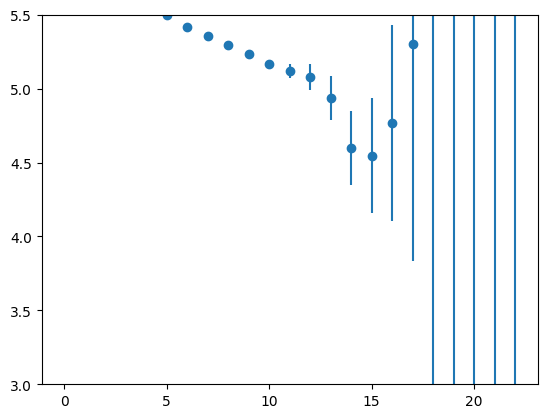

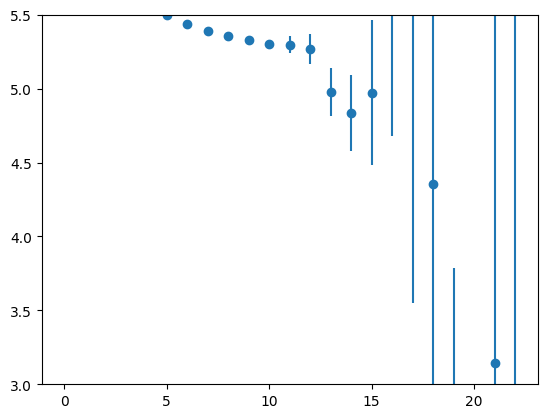

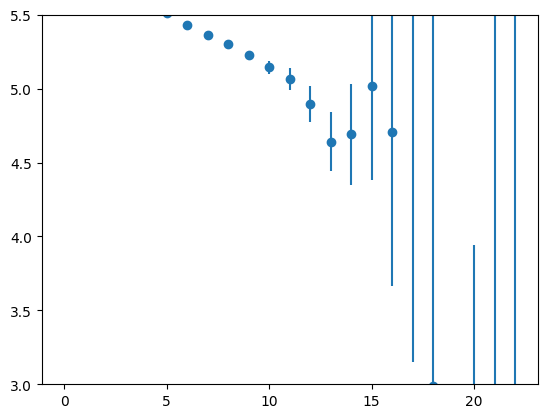

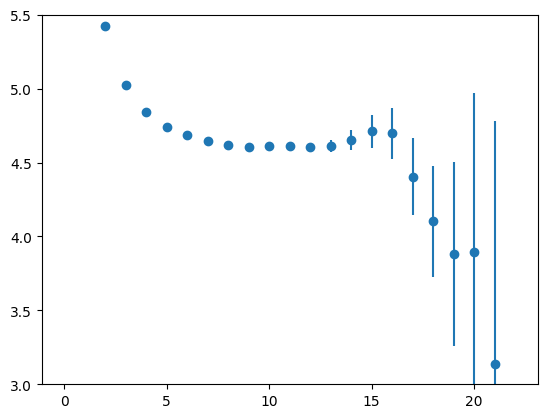

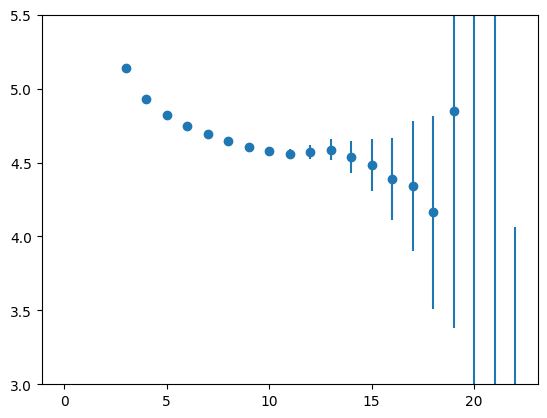

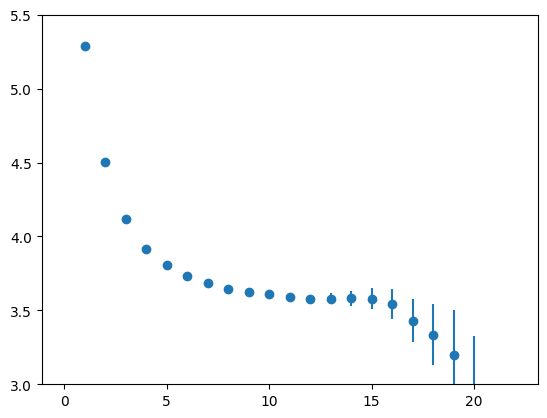

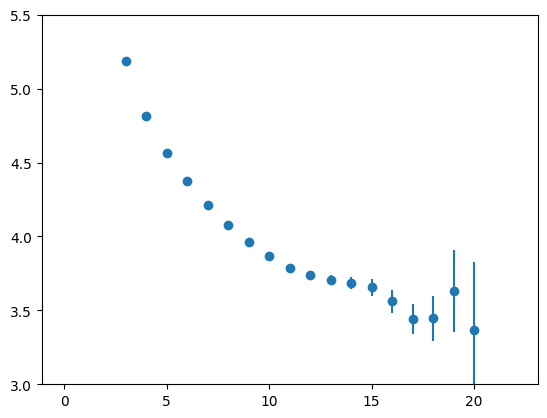

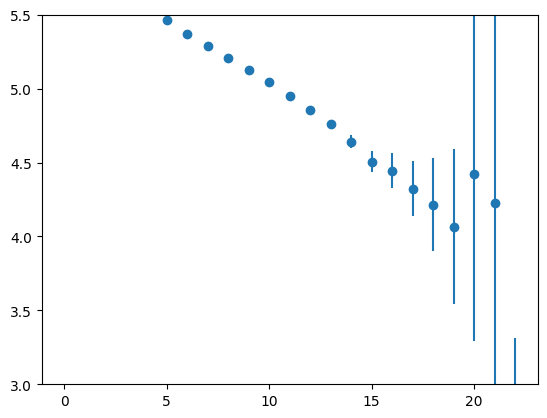

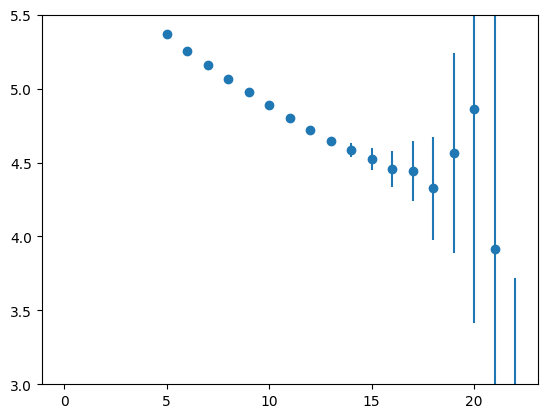

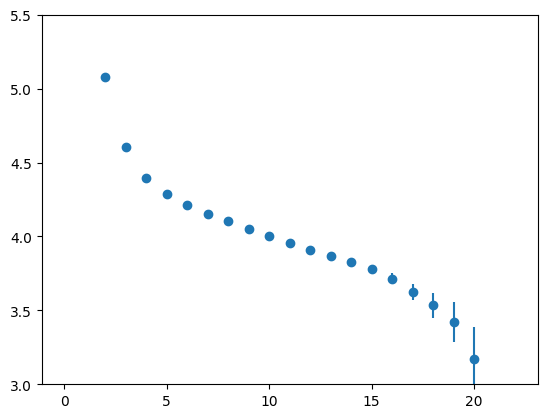

In [8]:
for i in range(NOPS):
    c00=corrMatrix[:,:,i,i]
    effMass=jackKnife(log_effective_mass, c00.real)
    plt.errorbar([t for t in range(len(effMass[0]))], effMass[0].real/mpi, yerr=effMass[1].real/mpi,
        linestyle="None", marker="o")
    plt.ylim(3,5.5)
    plt.show()

## Removing One Op

In [9]:
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
# fitTypes['double']={'fcn': double_exp, 'p0': p0_double()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

allOps = [o for o in range(NOPS)]
opBasis = [[o for o in range(NOPS)] for i in range(NOPS)]
for i,lst in enumerate(opBasis[0:2]):
    lst.pop(i)
opBasis.append(allOps)

subCorrMatrix = lambda ops : corrMatrix.take(ops, axis=3).take(ops, axis=2)

def get_allEnergies(t0,td):
    allEnergies={'mavg': {}, 'best': {}}
    fitEns=5
    for idx,ops in enumerate(opBasis):
        pivotedCorr=get_pivoted_corr(subCorrMatrix(ops),t0,td)

        getModelAvg = lambda en : perform_model_avg(pivotedCorr, en, fitTypes, t0, NT, mpi)
        getBestFit = lambda en: perform_best_fit(pivotedCorr, en, fitTypes, t0, NT, mpi)

        mpPool = MP.Pool(6)    
        mAvgs = list(mpPool.map(getModelAvg, range(fitEns)))
        bestFits = list(mpPool.map(getBestFit, range(fitEns)))

        allEnergies['mavg'][idx]=mAvgs
        allEnergies['best'][idx]=bestFits

        print("done with op set {}".format(idx))
        pivotedCorr=None
    return allEnergies

In [11]:
### t0=3, td=5

t0=3
td=5
corrMatrix=corrMatrix.astype(np.complex64)
allEnergies=get_allEnergies(t0=t0,td=td)

done with op set 0
done with op set 1
done with op set 2
done with op set 3
done with op set 4
done with op set 5
done with op set 6
done with op set 7
done with op set 8
done with op set 9
done with op set 10


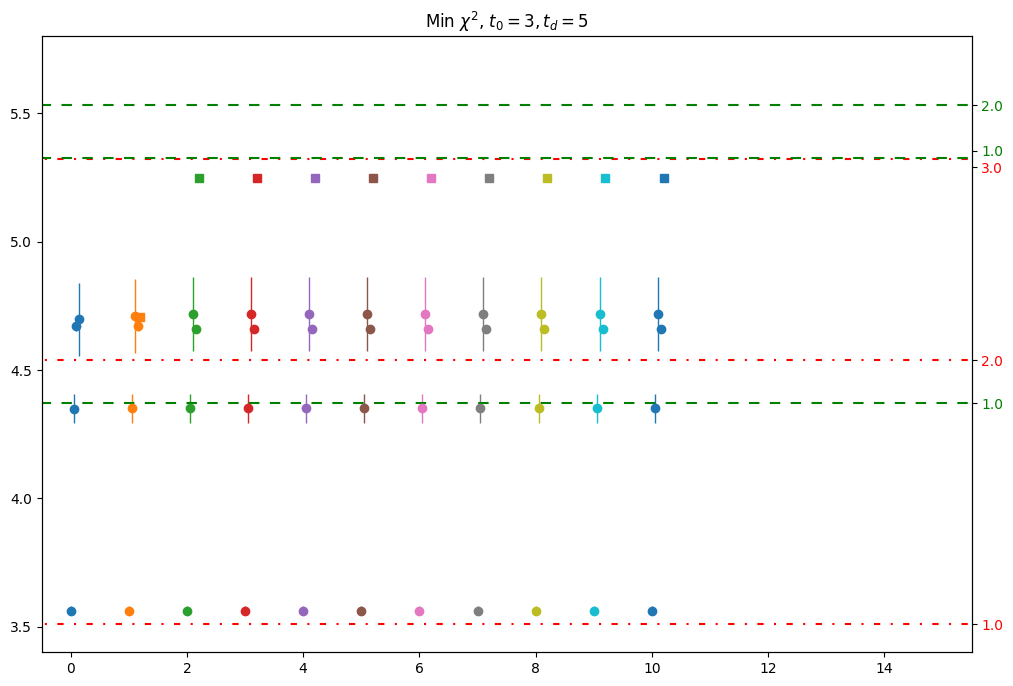

In [18]:
plt.figure(figsize=(12,8))
plot_fit_results(allEnergies,'best',mpi)
plt.xlim(-0.5,15.5)
plt.ylim(3.4,5.8)
# plot ni levels after to get correct ylim
plot_ni_levels(niData)
plt.title('Min $\chi^2$, $t_0={}, t_d={}$'.format(t0,td))
plt.show()

## All Ops t0,td

In [19]:
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
# fitTypes['double']={'fcn': double_exp, 'p0': p0_double()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

#niData=niFile_to_dict("L4848_a2g.hdf5","A2g")

allEnergies={'mavg': {}, 'best': {}}
fitEns=8
for t0 in range(2,8):
    for td in range(t0+1, 2*t0+1):
        if td<NT-2:
            pivotedCorr=get_pivoted_corr(corrMatrix,t0,td)

            getModelAvg = lambda en : perform_model_avg(pivotedCorr, en, fitTypes, t0, NT, mpi)
            getBestFit = lambda en: perform_best_fit(pivotedCorr, en, fitTypes, t0, NT, mpi)

            mpPool = MP.Pool(6)    
            mAvgs = list(mpPool.map(getModelAvg, range(fitEns)))
            bestFits = list(mpPool.map(getBestFit, range(fitEns)))

            #getFits = lambda en : perform_many_fits(pivotedCorr, en, fitTypes, t0, NT, mpi)
            #mpPool = MP.Pool(6)    
            #allFitData = list(mpPool.map(getFits, range(fitEns)))
            
            #mAvgs=[]
            #bestFits=[]
            #for en in range(fitEns):
            #    allFits, model_probs, energies = allFitData[en]
            
            #    allFits, model_probs, energies = remove_bad_fits(allFits, model_probs, energies, mpi)
            #    mAvgs.append(model_avg(energies, model_probs))
            #    bestFits.append(min_chi2_fit(energies, allFits))


            tLabel = "{},{}".format(t0,td)
            allEnergies['mavg'][tLabel]=mAvgs
            allEnergies['best'][tLabel]=bestFits

    print("Done fitting for t0={}".format(t0))

Done fitting for t0=2
Done fitting for t0=3
Done fitting for t0=4
Done fitting for t0=5
Done fitting for t0=6
Done fitting for t0=7


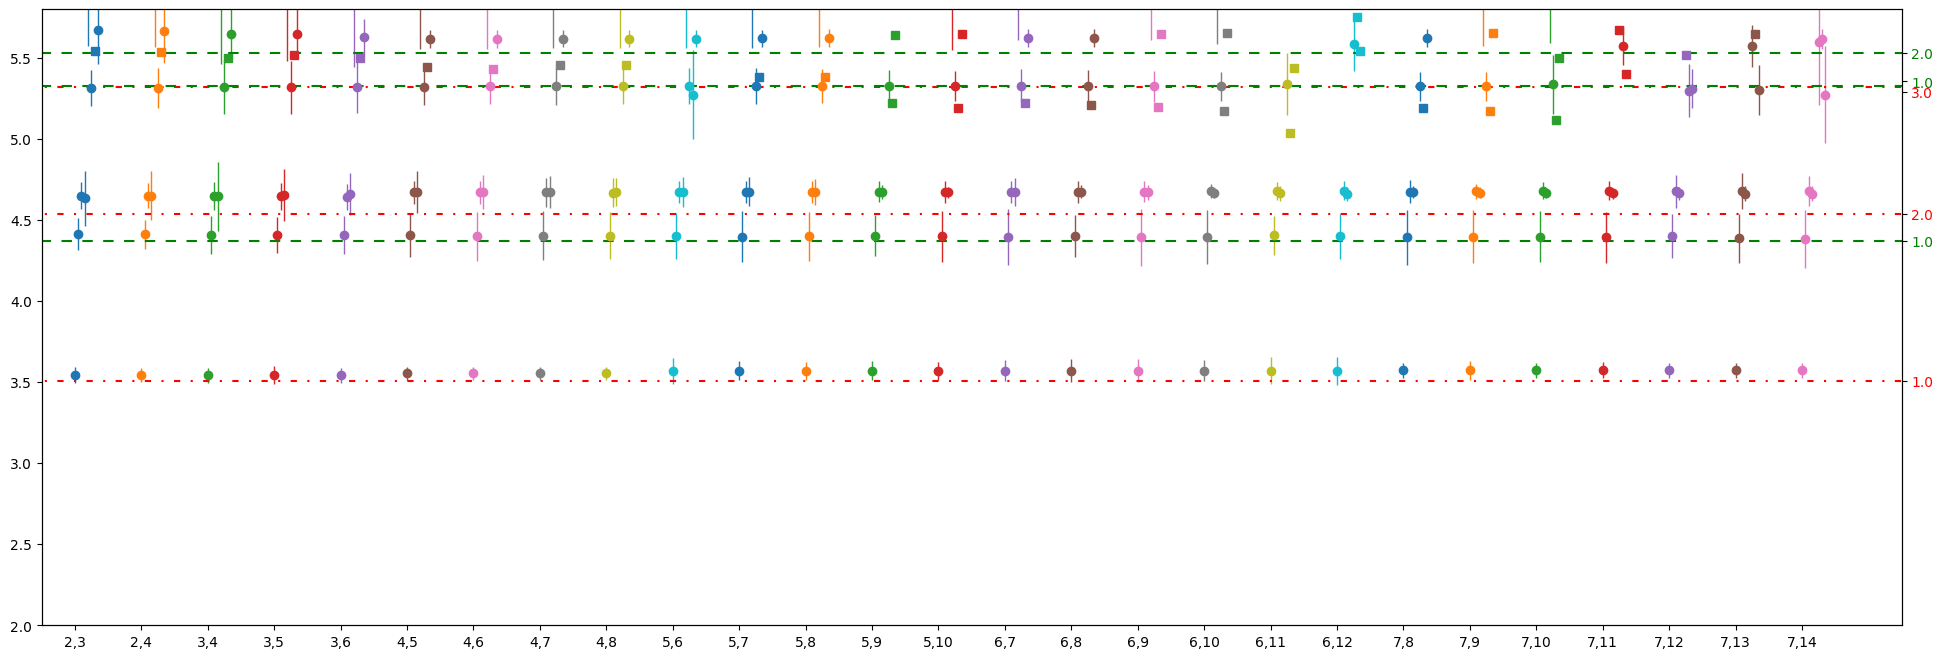

In [21]:
#niData=niFile_to_dict("L4848_a2g.hdf5","A2g")
plt.figure(figsize=(24,8))
plot_t0td_fit_results(allEnergies, 'mavg', mpi)
plt.xlim(-0.5,len(allEnergies['mavg'])+0.5)
plt.ylim(2.0,5.8)
plot_ni_levels(niData)

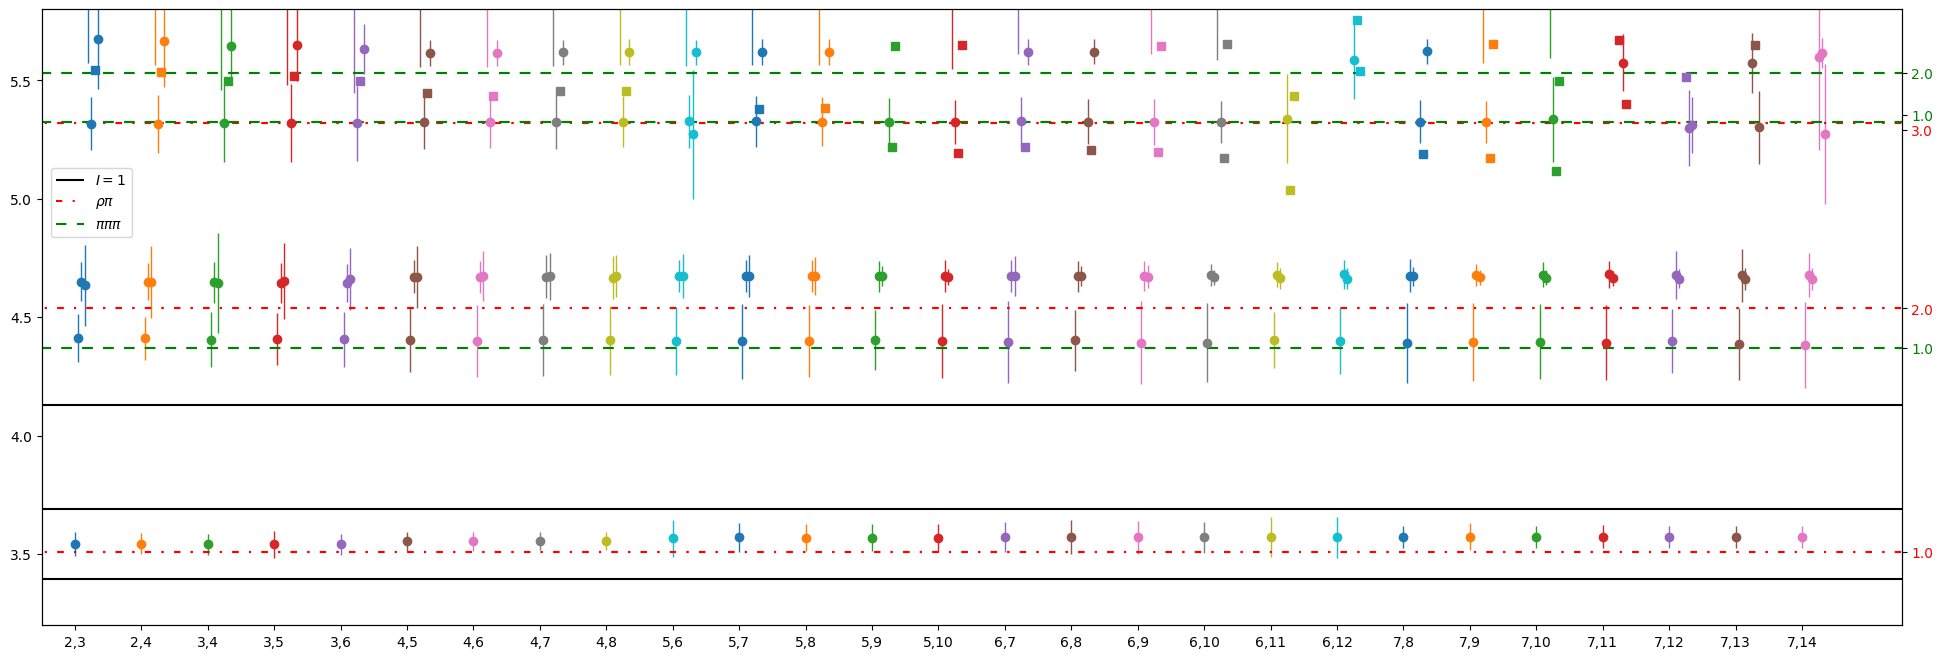

In [53]:
#niData=niFile_to_dict("L4848_a2g.hdf5","A2g")
plt.figure(figsize=(24,8))
plot_t0td_fit_results(allEnergies, 'mavg', mpi)
plt.hlines([3.39654,3.691,4.13],-1,40, colors='black', label=r'$I=1$')
plt.xlim(-0.5,len(allEnergies['mavg'])+0.5)
plt.ylim(3.2,5.8)
plt.hlines(get_ni_ens(niData, 'rhopi'),xmin=-11,xmax=100, linestyle=(0, (3, 5, 1, 5)),color='red', label=r'$\rho\pi$')
#plt.hlines(get_ni_ens(opData, 'sigmapi'),xmin=-11,xmax=100, linestyle=(0, (1,1)),color='blue')
plt.hlines(get_ni_ens(niData, 'threepi'),xmin=-11,xmax=100, linestyle=(0, (5,5)),color='green', label=r'$\pi\pi\pi$')
plt.legend(loc=(0.005,0.63))
plot_ni_levels(niData)

## Picking best

In [22]:
t0=5
td=9
pivotedCorr=get_pivoted_corr(corrMatrix,t0,td)
allFitInfos={}

3.570(41)


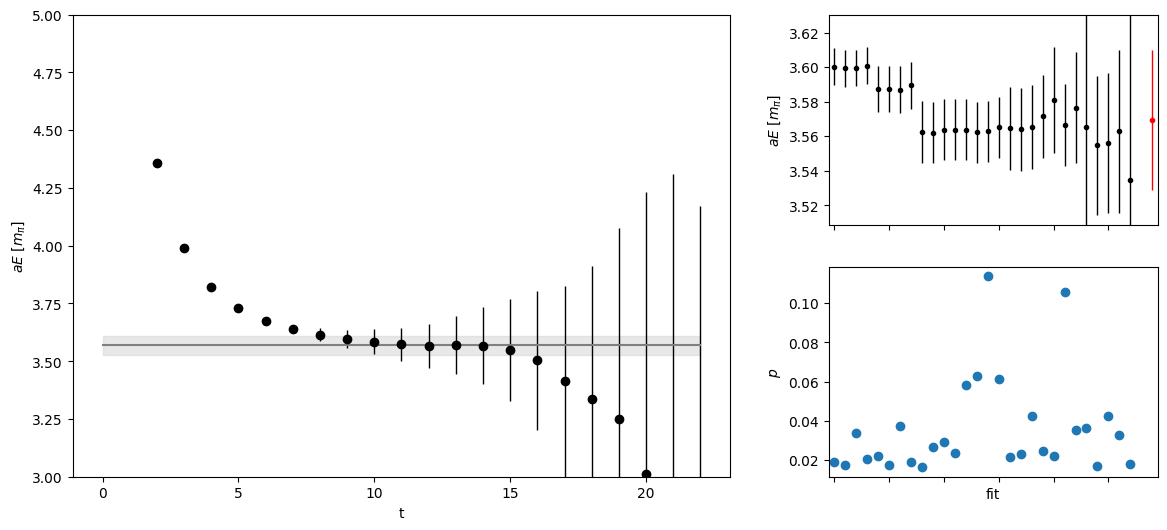

In [23]:
en=0
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}
allFits, fitinfos, model_probs, energies = perform_many_fits(pivotedCorr, en, fitTypes, t0, NT-2, mpi)
allFits, fitinfos, model_probs, energies = remove_bad_fits(allFits, fitinfos, model_probs,energies, mpi, sdevCut=0.5, probCut=0.01
)
mAvg=model_avg(energies, model_probs)
print(mAvg/mpi)
model_average_summary_plot(pivotedCorr, en, energies, model_probs, mAvg, mpi, emYlim=[3,5])

allFitInfos[en]=fitinfos

4.410(59)


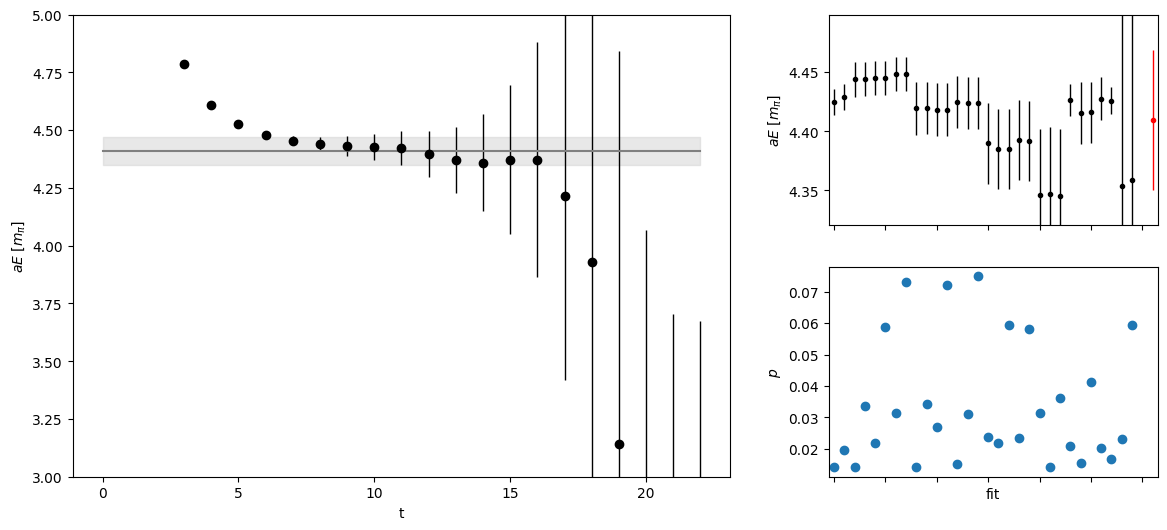

In [24]:
en=1
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}
allFits, fitinfos, model_probs, energies = perform_many_fits(pivotedCorr, en, fitTypes, t0, NT-2, mpi)
allFits, fitinfos, model_probs, energies = remove_bad_fits(allFits, fitinfos, model_probs,energies, mpi, sdevCut=0.5, probCut=0.01
)
mAvg=model_avg(energies, model_probs)
print(mAvg/mpi)
model_average_summary_plot(pivotedCorr, en, energies, model_probs, mAvg, mpi, emYlim=[3,5])

allFitInfos[en]=fitinfos

4.675(38)


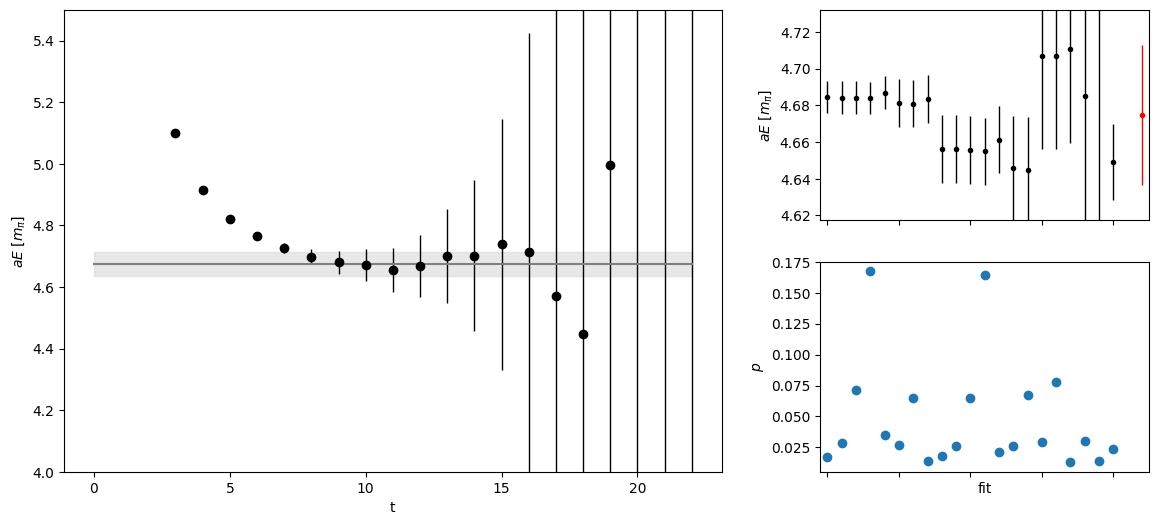

In [25]:
en=2
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}
allFits, fitinfos, model_probs, energies = perform_many_fits(pivotedCorr, en, fitTypes, t0, NT-2, mpi)
allFits, fitinfos, model_probs, energies = remove_bad_fits(allFits, fitinfos, model_probs,energies, mpi, sdevCut=0.5, probCut=0.01
)
mAvg=model_avg(energies, model_probs)
print(mAvg/mpi)
model_average_summary_plot(pivotedCorr, en, energies, model_probs, mAvg, mpi, emYlim=[4,5.5])

allFitInfos[en]=fitinfos

4.669(22)


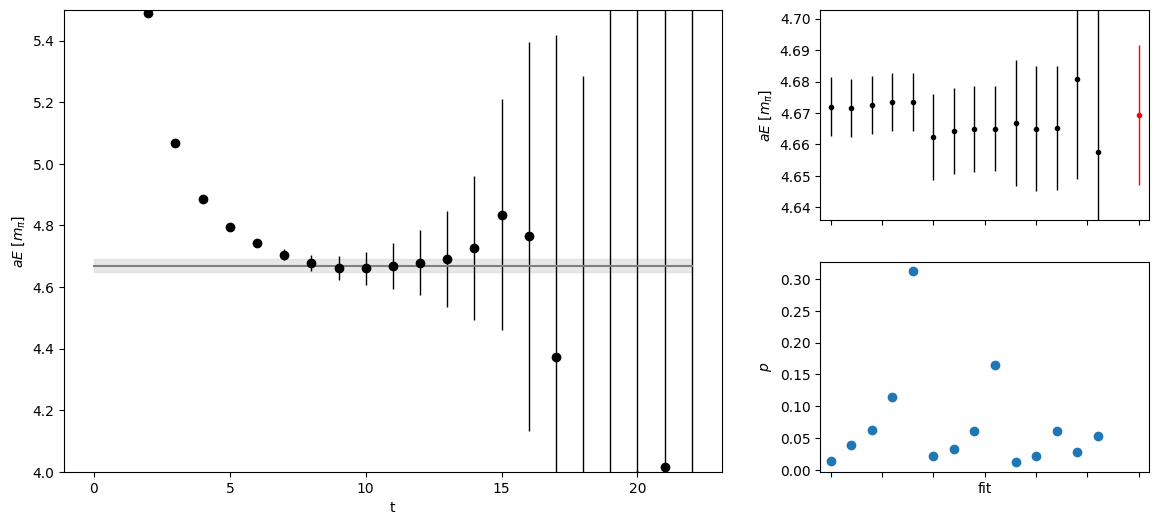

In [26]:
en=3
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}
allFits, fitinfos, model_probs, energies = perform_many_fits(pivotedCorr, en, fitTypes, t0, NT-2, mpi)
allFits, fitinfos, model_probs, energies = remove_bad_fits(allFits, fitinfos, model_probs,energies, mpi, sdevCut=0.5, probCut=0.01
)
mAvg=model_avg(energies, model_probs)
print(mAvg/mpi)
model_average_summary_plot(pivotedCorr, en, energies, model_probs, mAvg, mpi, emYlim=[4,5.5])

allFitInfos[en]=fitinfos

5.327(45)


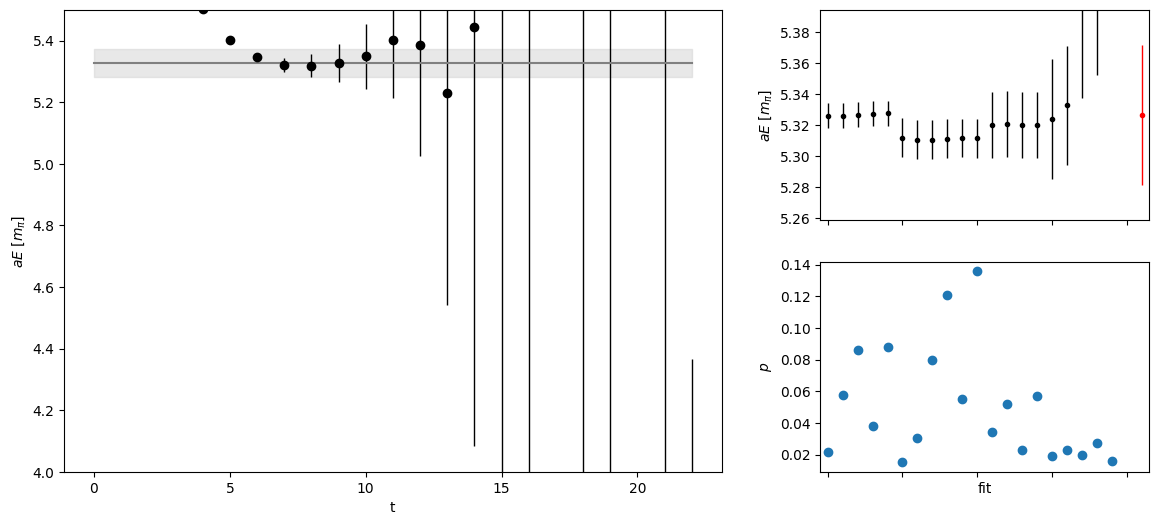

In [28]:
en=5
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}
allFits, fitinfos, model_probs, energies = perform_many_fits(pivotedCorr, en, fitTypes, t0, NT-2, mpi)
allFits, fitinfos, model_probs, energies = remove_bad_fits(allFits, fitinfos, model_probs,energies, mpi, sdevCut=0.5, probCut=0.01
)
mAvg=model_avg(energies, model_probs)
print(mAvg/mpi)
model_average_summary_plot(pivotedCorr, en, energies, model_probs, mAvg, mpi, emYlim=[4,5.5])

allFitInfos[en]=fitinfos

In [29]:
samples = get_pivoted_corr_samples(corrMatrix,t0,td)
cov = get_pivoted_corr(corrMatrix,t0,td)[1]

In [30]:
en=0
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

en0samples=perform_good_fits_on_resamples(en, samples, cov, allFitInfos[en], fitTypes, t0, NT)

en=1
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

en1samples=perform_good_fits_on_resamples(en, samples, cov, allFitInfos[en], fitTypes, t0, NT)

en=2
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

en2samples=perform_good_fits_on_resamples(en, samples, cov, allFitInfos[en], fitTypes, t0, NT)

en=3
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

en3samples=perform_good_fits_on_resamples(en, samples, cov, allFitInfos[en], fitTypes, t0, NT)

en=5
fitTypes={}
fitTypes['single']={'fcn': single_exp, 'p0': p0_single()}
fitTypes['triple']={'fcn': triple_exp, 'p0': p0_triple()}

en5samples=perform_good_fits_on_resamples(en, samples, cov, allFitInfos[en], fitTypes, t0, NT)

In [31]:
print(np.mean(en0samples)/mpi)
print(np.mean(en1samples)/mpi)
print(np.mean(en2samples)/mpi)
print(np.mean(en3samples)/mpi)
print(np.mean(en5samples)/mpi)

3.5690091392566656
4.411201355444396
4.674926717366662
4.669876457642893
5.326620281515443


In [32]:
import h5py
import os

In [33]:
fileDir=os.path.join(os.path.expanduser("~"),"Downloads")
file=h5py.File(os.path.join(fileDir,"L2448_energies.hdf5"),"w")
dataSet=file.create_dataset("E0",np.array(en0samples).shape)
dataSet[:]=en0samples
dataSet=file.create_dataset("E1",np.array(en1samples).shape)
dataSet[:]=en1samples
dataSet=file.create_dataset("E2",np.array(en2samples).shape)
dataSet[:]=en2samples
dataSet=file.create_dataset("E3",np.array(en3samples).shape)
dataSet[:]=en3samples
dataSet=file.create_dataset("E5",np.array(en5samples).shape)
dataSet[:]=en5samples
file.close()